# Gaussian Mixture Models

## Importing necessary libs

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


## Generating data

First let's generate isotropic Gaussian blobs for clustering with sklearn.datasets.make_blobs function. There are total 400 data-points for 4 cluster, the visualization is shown below.

In [208]:
# Generate some data
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [209]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

Text(0.5, 1.0, 'Ground Truth')

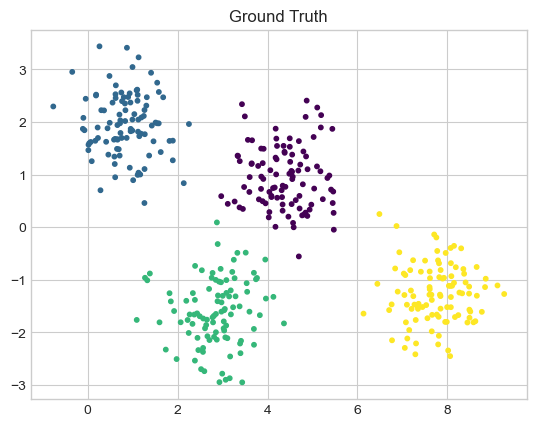

In [210]:
# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=10, cmap='viridis')
plt.title("Ground Truth")

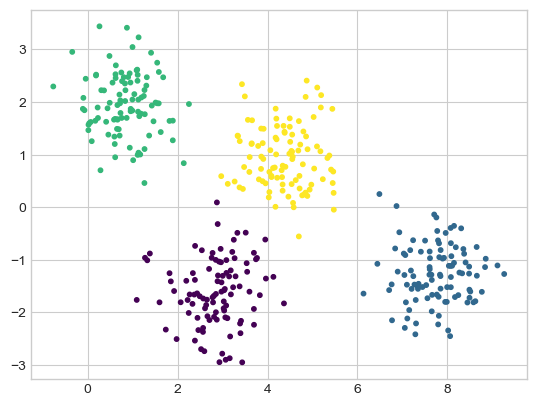

In [211]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');

In [212]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, ec='black', fc='lightgray',
                                lw=3, alpha=0.5, zorder=1))

## Visualize KMeans algorithm results

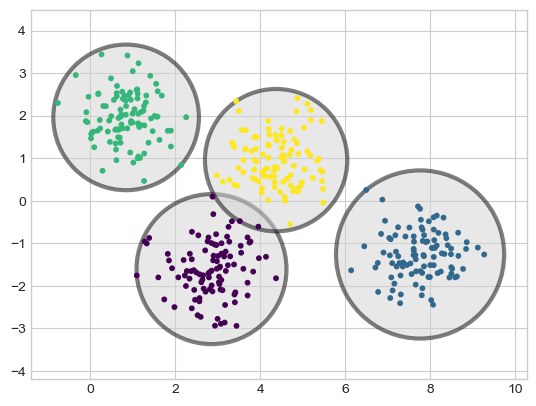

In [213]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

## GMM model from scratch

Now, we may dive into Gaussian Mixture Model to see its efficiency in clustering

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

In [247]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X, plot_results=False, plot_every = 0):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            if plot_results:
                if iteration % plot_every == 0:
                    labels = self.predict(X)
                    # plot the input data
                    fig, ax = plt.subplots()
                    ax = ax or plt.gca()
                    ax.axis('equal')
                    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
                    ax.set_title("Iteration {i}-th".format(i = iteration))
     
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [248]:
np.random.seed(0)
gmm = GMM(k=4, max_iter=26)
gmm.fit(X)

### Expected values of each component (distribution)

In [249]:
gmm.mu

[array([ 7.76344696, -1.27781925]),
 array([0.83735904, 1.95812575]),
 array([ 2.84402722, -1.62832794]),
 array([4.36380955, 0.93073822])]

### Covariance matrix of each distribution

In [250]:
gmm.sigma

[array([[0.36410031, 0.01480285],
        [0.01480285, 0.28727217]]),
 array([[ 0.29742221, -0.0242404 ],
        [-0.0242404 ,  0.34161953]]),
 array([[0.38458464, 0.02712812],
        [0.02712812, 0.37391369]]),
 array([[ 0.40874532, -0.00378775],
        [-0.00378775,  0.36949268]])]

In [251]:
gmm.weights.sum(axis=0)/gmm.weights.sum()

# (if there is a new data, what is the probability that it belongs to one of 4 clusters)

array([0.24854765, 0.24959172, 0.2470176 , 0.25484303])

In [252]:
def plot_simple_gaussian(gmm, X, n_clusters=4, ax=None):
    labels = gmm.predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
    ax.set_title('Gaussian Mixture Model Result')

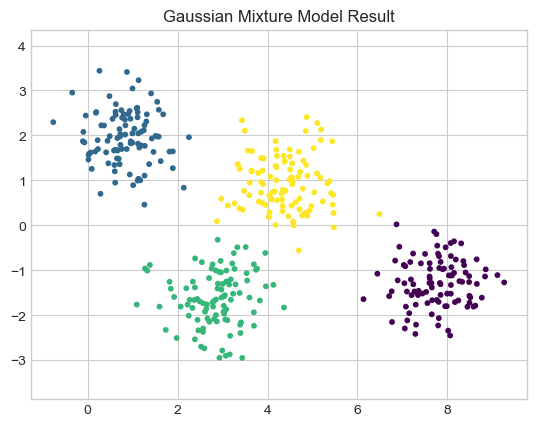

In [253]:
plot_simple_gaussian(gmm, X)

## Plotting performance of Gaussian Mixture Model through time

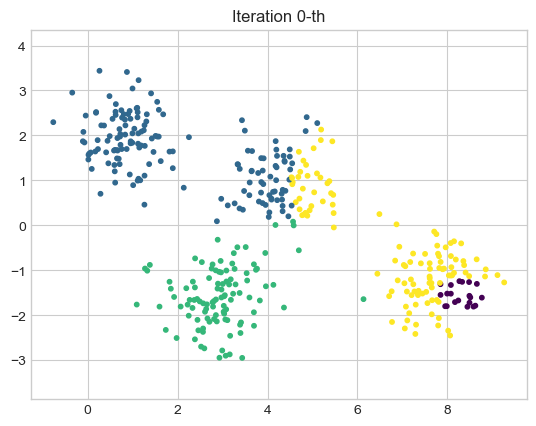

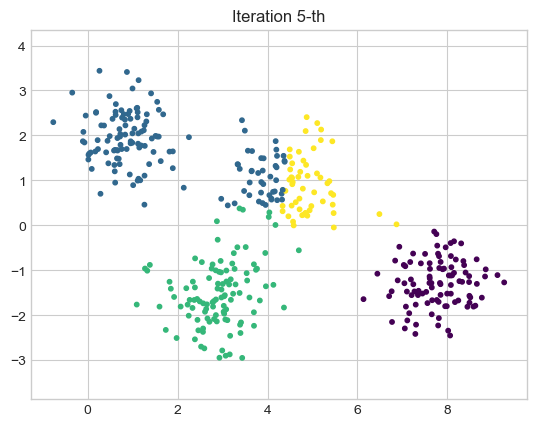

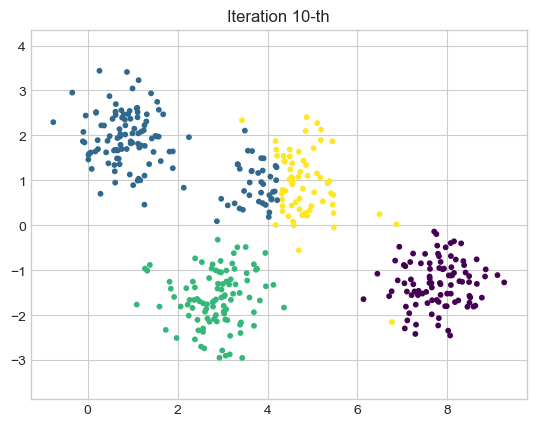

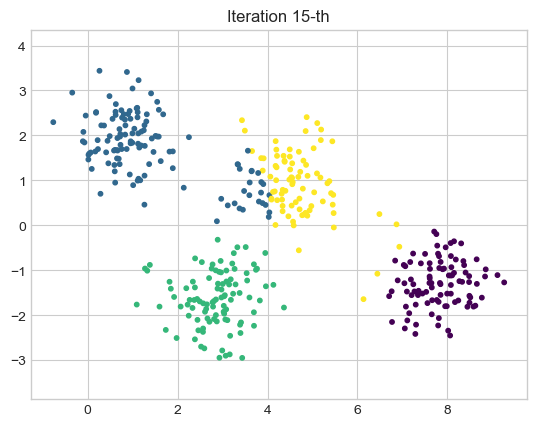

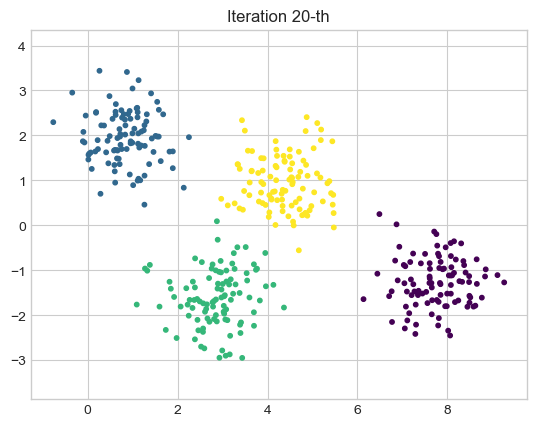

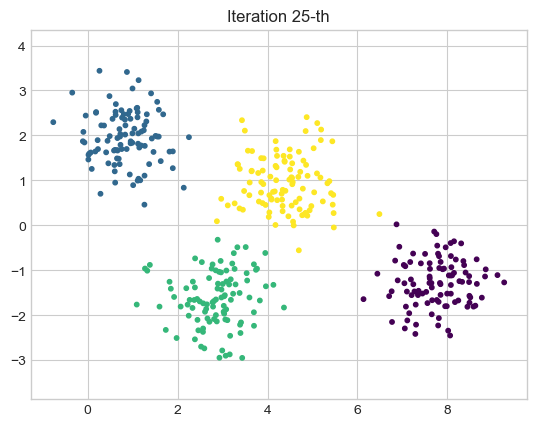

In [254]:
np.random.seed(0)
gmm = GMM(k=4, max_iter=26)
gmm.fit(X, plot_results=True, plot_every=5)

## Stretching data

In [255]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

Text(0.5, 1.0, 'Ground Truth')

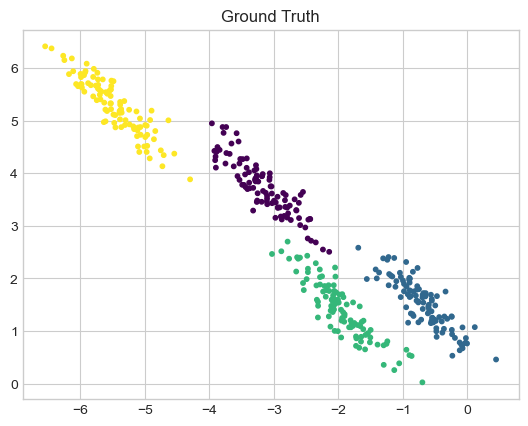

In [256]:
# Plot the data
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y_true, s=10, cmap='viridis')
plt.title("Ground Truth")

### Disadvantages of K-means algorithms and why GMM?
These two disadvantages of k-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope. A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset

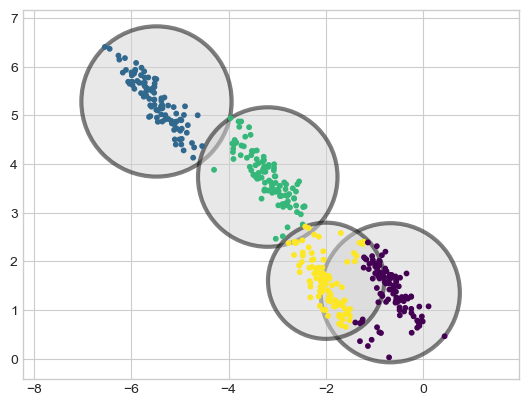

In [257]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

In [258]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=20, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / (gmm.weights.sum(axis=0)/gmm.weights.sum()).max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.weights.sum(axis=0)/gmm.weights.sum()):
        draw_ellipse(pos, covar, alpha=w * w_factor)

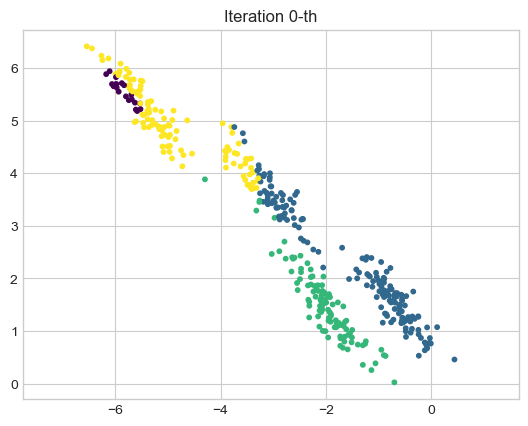

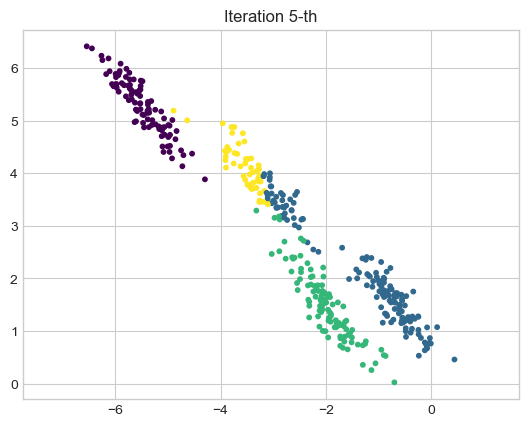

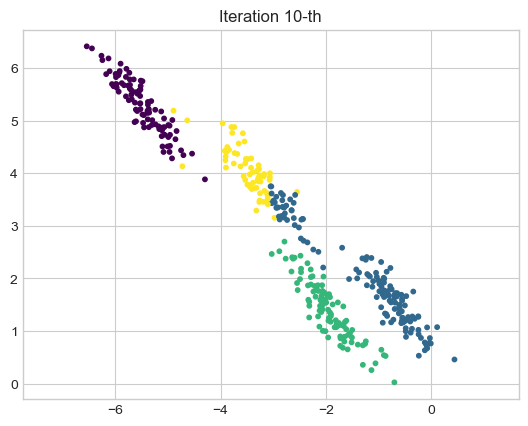

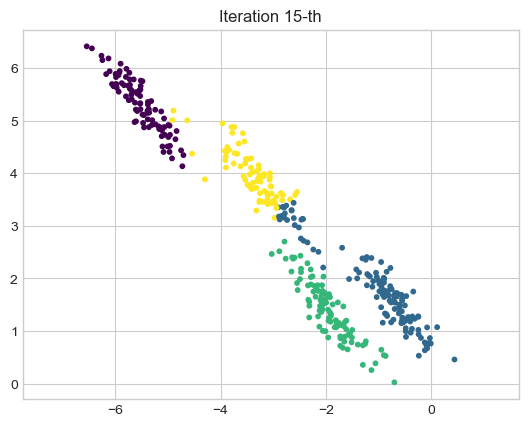

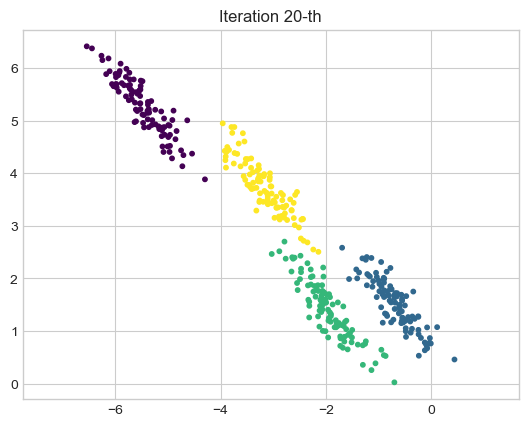

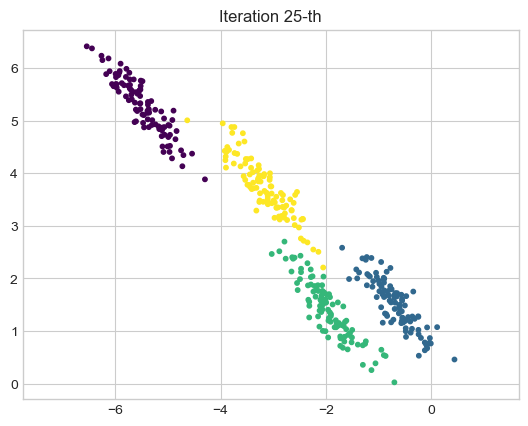

In [259]:
np.random.seed(0)
gmm = GMM(k=4, max_iter=26)
gmm.fit(X_stretched, plot_results=True, plot_every=5)

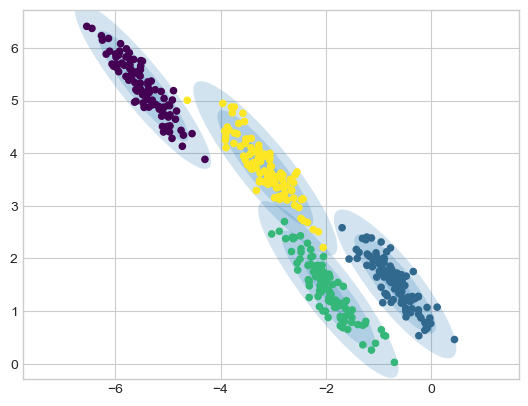

In [260]:
plot_gmm(gmm, X_stretched)